In [1]:
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import json

Valassis Digital has run a digital advertising campaign for one of our clients, targeting mobile users in the Southeast. We ran two creatives (distinct ad designs) during the campaign: a baseline creative in line with our client's previous campaigns, and a new creative designed to increase conversions. Users in a "test" group received the new ad during the campaign. The goal of my analysis was to answer 2 questions. Did the new creative increase conversions? Would retargeting have improved performance for this campaign?


## Data Prep

In [2]:
users=pd.read_csv('user_attributes.csv')

In [3]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [4]:
bids=pd.read_csv('bid_requests.csv')
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [5]:
columns=list(json.loads(users['attributes'][0]).keys())

In [6]:
users2=pd.DataFrame(np.asarray(list(users['attributes'].apply(lambda x: sorted(json.loads(x).items()))))[:,:,1],columns=columns)
users2['user_id']=users['user_id']
users2.head()

,age,gender,location,test,user_id
0,33,F,FL,1,00003e3b9e5336685200ae85d21b4f5e
1,26,M,AL,1,000053b1e684c9e7ea73727b2238ce18
2,29,F,AR,1,00029153d12ae1c9abe59c17ff2e0895
3,29,M,SC,0,0002ac0d783338cfeab0b2bdbd872cda
4,27,F,AR,1,0004d0b59e19461ff126e3a08a814c33


In [7]:
users2['test']=users2['test'].apply(lambda x: int(x))
users2['age']=users2['age'].apply(lambda x: float(x))

In [8]:
users2=users2.drop_duplicates().reset_index(drop=True)
bids=bids.drop_duplicates().reset_index(drop=True)
final=users2.merge(bids,on='user_id',how='left')

In [9]:
bids=bids.dropna().reset_index(drop=True)
users2=users2.dropna().reset_index(drop=True)
final=final.dropna().reset_index(drop=True)
final.head()

,age,gender,location,test,user_id,timestamp,bid,win,conversion
0,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-01 13:43:34,1.0,0.0,0.0
1,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 03:59:18,0.0,0.0,0.0
2,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 17:41:50,1.0,1.0,0.0
3,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-07 04:02:42,1.0,1.0,0.0
4,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-08 09:05:01,1.0,0.0,0.0


In [10]:
test=pd.DataFrame(users2[users2['test']==1])
control=pd.DataFrame(users2[users2['test']==0])

In [11]:
test2=pd.DataFrame(final[final['test']==1])
control2=pd.DataFrame(final[final['test']==0])

## Find obvious bias

In [12]:
print('Sizes:Test {},Control {}'.format(len(test), len(control)))

Sizes:Test 56084,Control 43916


In [13]:
print('Gender in the test group')
test['gender'].value_counts()/len(test)*100

Gender in the test group


F    50.117681
M    49.882319
Name: gender, dtype: float64

In [14]:
print('Gender  in the control group')
control['gender'].value_counts()/len(control)*100

Gender  in the control group


M    50.325622
F    49.674378
Name: gender, dtype: float64

#### Gender distributions in the test and control groups were about the same

Text(0.5, 1.0, 'Location in the test group')

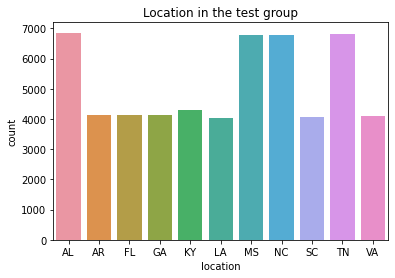

In [15]:
sb.countplot(test['location'].sort_values())
plt.title('Location in the test group')

Text(0.5, 1.0, 'Location in the control group')

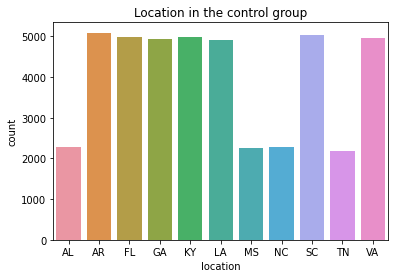

In [16]:
sb.countplot(control['location'].sort_values())
plt.title('Location in the control group')

#### Location distributions in the test and control groups were different

In [17]:
print('Age in the test and control groups')
print('Medians: Test {},Control {}'.format(np.median(test['age']), np.median(control['age'])))
print('Means: Test {},Control {}'.format(np.mean(test['age']), np.mean(control['age'])))
print('Standard Deviation: Test {},Control {}'.format(np.std(test['age']),np.std(control['age'])))

Age in the test and control groups
Medians: Test 25.0,Control 25.0
Means: Test 25.493830682547607,Control 25.488364149740413
Standard Deviation: Test 4.6043110471866955,Control 4.599852715678207


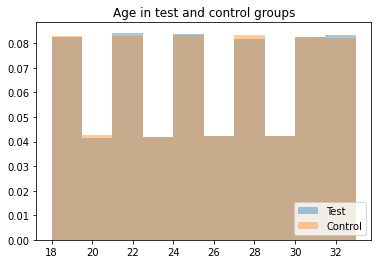

In [18]:
plt.hist(test['age'], density=True,label = "Test", alpha = .4)
plt.hist(control['age'],density=True,label = 'Control', alpha = .4)
plt.title('Age in test and control groups')
plt.legend(loc ='lower right')

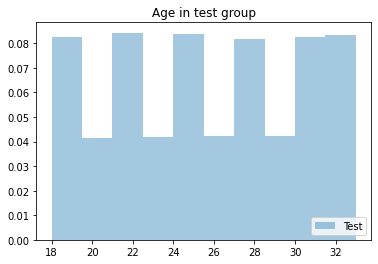

In [19]:
plt.hist(test['age'], density=True,label = "Test", alpha = .4)

plt.title('Age in test group')
plt.legend(loc ='lower right')

#### Age distributions in the test and control groups were about the same

## Experiment results

In [20]:
print("Percentage of Bids")
print('Test {},Control {}'.format(np.mean(test2['bid'])*100,np.mean(control2['bid'])*100))

Percentage of Bids
Test 49.97025685646047,Control 49.977680870789406


In [21]:
#only look at wins for bids
bidtest=test2[test2['bid']==1]
bidcontrol=control2[control2['bid']==1]

print("Percentage of Bids Won")
print('Test {},Control {}'.format(np.mean(bidtest['win'])*100,np.mean(bidcontrol['win'])*100))

Percentage of Bids Won
Test 50.101867974367174,Control 50.05076529638536


In [22]:
#only look at conversions for wins in each group
wintest=test2[test2['win']==1]
wincontrol=control2[control2['win']==1]

print("Conversion rate")
print('Test {},Control {}'.format(np.mean(wintest['conversion'])*100,np.mean(wincontrol['conversion'])*100))

Conversion rate
Test 4.009693244281578,Control 4.153193825880056


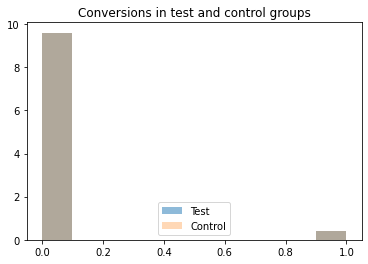

In [39]:
plt.hist(wintest['conversion'], density=True,alpha=0.5,label = "Test")
plt.hist(wincontrol['conversion'],density=True,alpha=0.3,label = 'Control')
plt.title('Conversions in test and control groups')
plt.legend(loc ='lower center')


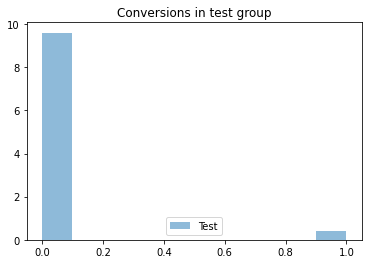

In [24]:
plt.hist(wintest['conversion'], density=True,label = "Test", alpha = .5)
#plt.hist(wincontrol['conversion'],density=True,label = 'Control', alpha = .5)
plt.title('Conversions in test group')
plt.legend(loc ='lower center')


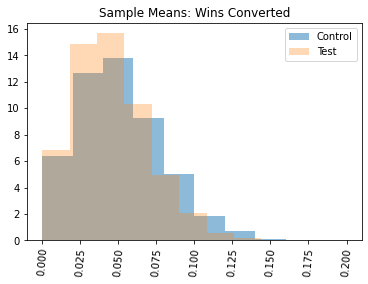

MannwhitneyuResult(statistic=2769213741.5, pvalue=0.08145325354797739)

In [25]:
#plot sample mean distributions and do p test
tests=[]
controls=[]


for i in range(10000):
    tes = np.random.choice(wintest['conversion'],50, replace=True).mean()
    con = np.random.choice(wincontrol['conversion'], 50, replace=True).mean()
    
    controls.append(con)
    tests.append(tes)

plt.hist(controls, alpha=0.5, density=True,label='Control') 
plt.hist(tests, alpha=0.3, density=True,label='Test') 
plt.xticks(rotation=85)
plt.legend(loc='upper right')
plt.title('Sample Means: Wins Converted')
plt.show()

mannwhitneyu(wintest['conversion'], wincontrol['conversion'])

#### DISTRIBUTION IS SKEWED.  P value for Mann Whitney U test shows that differences in conversion rates between test and control groups are probably random.

### Q-Q Plots

In [26]:
rand1=np.random.normal(1, .5, 100)
rand1.sort()
#tests and controls
wtest=np.random.choice(tests,100)
wcontrol=np.random.choice(controls,100)
wtest.sort()
wcontrol.sort()

Text(0.5, 1.0, 'Test sample means vs normal distribution')

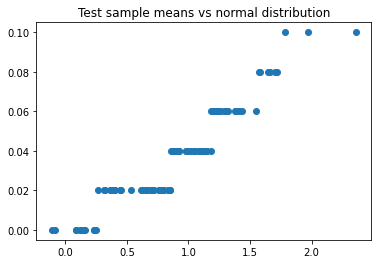

In [27]:
plt.plot(rand1,wtest,'o')
plt.title('Test sample means vs normal distribution')

Text(0.5, 1.0, 'Control sample means vs normal distribution')

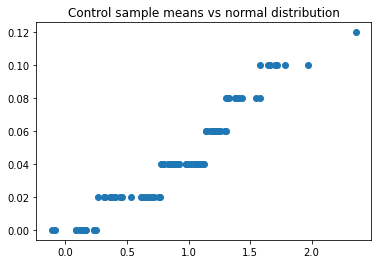

In [28]:
plt.plot(rand1,wcontrol,'o')
plt.title('Control sample means vs normal distribution')

## Retargeting

In [29]:
bidsgrp=pd.DataFrame(bids.groupby(['user_id'])[['bid','win','conversion']].sum())

In [30]:
rewin=pd.DataFrame(bidsgrp[bidsgrp['win']>1])
rewin['reconvert']=np.where(rewin['conversion']>1,1,0)

In [31]:
print("Percentage of users served more than once that converted more than once")
print(np.mean(rewin['reconvert'])*100)

Percentage of users served more than once that converted more than once
1.2141714525476621


####  *Doesn't make sense to target previously converted users

In [32]:
wins=pd.DataFrame(bids[bids['win']>0])
wins=wins.sort_values(['user_id','timestamp']).reset_index(drop=True)

In [33]:
#I don't know how many times they saw the ad outside the study period

In [34]:
save='goo'
times=[]
for i in wins['user_id']:
    if save==i:
        count+=1
    else:
        count=1
    times.append(count)
    save=i
wins['times']=times

In [35]:
converted=pd.DataFrame(wins[wins['conversion']==1])

In [36]:
converted.head()

,timestamp,user_id,bid,win,conversion,times
15,2017-01-13 02:52:36,0007cda84fafdcf42f96c4f4adb7f8ce,1,1,1,1
92,2017-01-07 22:03:12,002572981e2eebd53b48809982cd3684,1,1,1,2
153,2017-01-07 15:39:09,003ae4e8b9f59b0aa0910ba1f5e35735,1,1,1,1
159,2017-01-16 09:00:40,003bed21fddc817050c8fa11897fe660,1,1,1,3
165,2017-01-21 17:24:03,003da94355a506f1f294090c173e7b73,1,1,1,4


Text(0.5, 1.0, 'User impressions before conversion')

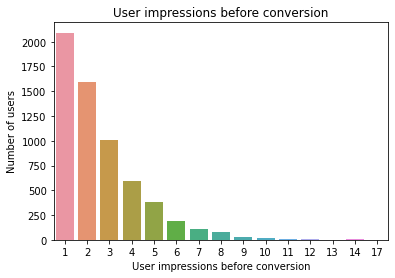

In [37]:
fig=sb.countplot(converted['times'])
fig.set(xlabel="User impressions before conversion",ylabel="Number of users")
plt.title('User impressions before conversion')

####  *Doesn't make sense to target previous visitors

Exercises / Questions
    1. What do the different distributions of requests by user tell us?
    
The distributions of user characteristics in the test and control groups were about the same except for their locations. Some bias was introduced due to the distribution of user locations being different in the test and control groups.

The percentage of bids and bids won were about the same for the test and control groups, but the percentage of wins converted was slightly higher in the control group. I looked at the distribution of sample means for wins converted and I found that it was skewed. I used a Mann Whitney U test to see if the differences between the test and control results were random. The p-value is above 0.05, which means that the slight difference between the test and control results was probably random and not a result of changing the ad creative.

    2. Based on insights from #1, was the test effective?
Were test users more likely to convert than control users? No.


    3. Should we consider retargeting users that have previously converted?
Would retargeting users in this campaign have improved performance? Only one percent of users served more than once converted more than once. Retargeting previously converted users probably would not have made a big difference. Additionally, inside the campaign period the conversion rate did not increase as the number of user impressions increased. Probably it would not have made sense to target previous visitors.